# Lecture 6 - Local Regression

## Today's Learning Goals

By the end of this lecture, you should be able to:

- Define the concept of local regression.
- Model and perform piecewise constant, linear, and continuous linear local regressions.
- Extend the concept of $k$-NN classification to a regression framework.
- Define and apply locally weighted scatterplot smoother regression.

## Loading Libraries

In [1]:
options(repr.matrix.max.rows = 10)
source("../scripts/support_functions.R")
library(tidyverse)
library(broom)
library(modelr)
library(caret)
library(gridExtra)

── Attaching core tidyverse packages ──────────────────────────────────────────────────────────────────────────────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors

Attaching package: ‘modelr’


The following object is masked from ‘package:broom’:

    bootstrap


Loading required package: lattice


Attaching package: ‘caret’


The following object is masked from ‘package:purrr’:

    lift



Attaching package: ‘gridExtra’


The following object is masked from ‘package:dplyr’:

    combine



It is time to put aside regression techniques on the global conditioned mean and check local alternatives suitable for predictions.

````{div} full-width
```{figure} ../img/reg-mindmap-6.png
:height: 600px
:name: reg-mindmap-6
Expanded regression modelling mind map (click on the image to zoom in).
```
````

## 1. Piecewise Local Regression

Retaking our initial motivation in this course, the classical linear regression model (Ordinary Least-squares, OLS) is focused on the conditional mean on the regressors:


$$
\mathbb{E}(Y_i \mid X_{i,j} = x_{i,j}) = \beta_0 + \beta_1 x_{i,1} + \ldots + \beta_k x_{i,k} \; \; \; \; \text{since} \; \; \; \; \mathbb{E}(\varepsilon_i) = 0.
$$

We already stated that a model of this class, i.e. parametric, favours interpretability when we aim to make inference on the response and regressors.

Nonetheless, suppose our goal is an **accurate prediction** in many complex frameworks (e.g., non-linear). In that case, the global linearity in models such as the OLS case is not that flexible.

Therefore, we can use **local regression techniques**.

### 1.1. Piecewise Constant Regression

This regression technique is based on fitting different **local OLS regressions**. The **step function** is the key concept here.

```{important}
The idea behind the **step function** is to break the range of the regressor into intervals. In each interval, we adjust a constant. We obtain the average response in that interval.
```

Let us take the 2-$d$ framework. For the $i$th observation in the sample, suppose we have a respose $Y_i$ subject to a regressor $X_i$.

Instead of making a **global parametric assumption**, we break the range of the regressor into $q$ **knots** $c_1, c_2, \dots, c_q$. Hence, the regressor will be sectioned in bins changing from continuous to categorical. The step functions are merely **dummy variables**.

```{math}
\begin{equation*}
C_0(X_i) = I(X_i < c_1) =
\begin{cases}
1 \; \; \; \; \mbox{if $X_i < c_1$},\\
0 \; \; \; \; 	\mbox{otherwise.}
\end{cases}
\end{equation*}
```
```{math}
\begin{equation*}
C_1(X_i) = I(c_1 \leq X_i < c_2) =
\begin{cases}
1 \; \; \; \; \mbox{if $c_1 \leq X_i < c_2$},\\
0 \; \; \; \; 	\mbox{otherwise.}
\end{cases}
\end{equation*}
```

$$\vdots$$

```{math}
\begin{equation*}
C_{q - 1}(X_i) = I(c_{q-1} \leq X_i < c_q) =
\begin{cases}
1 \; \; \; \; \mbox{if $c_{q-1} \leq X_i < c_q$},\\
0 \; \; \; \; 	\mbox{otherwise.}
\end{cases}
\end{equation*}
```

```{math}
\begin{equation*}
C_q(X_i) = I(c_q \leq X_i) =
\begin{cases}
1 \; \; \; \; \mbox{if $c_q \leq X_i$},\\
0 \; \; \; \; 	\mbox{otherwise.}
\end{cases}
\end{equation*}
```

Then, we run an OLS model based on these previous step functions and not the continuous $X_i$.

The regression model becomes

$$
Y_i = \beta_0 + \beta_1 C_1(X_i) + \beta_2 C_2(X_i) + \dots + \beta_{q-1} C_{q-1}(X_i) + \beta_q C_q(X_i) + \varepsilon_i.
$$

```{attention}
The step function $C_0(X_i)$ does not appear in the model given that $\beta_0$ can be interpreted as the response's mean when $X_i < c_1$ (i.e., the rest of the $q$ step functions are equal to zero).
```

**Cow Milk Dataset**

We will use the dataset provided by [Henderson and McCulloch (1990)](https://ecommons.cornell.edu/bitstream/handle/1813/31620/BU-1049-MA.pdf;jsessionid=1E54532D482EC351824111A78C797021?sequence=1). The **whole dataset** contains the average daily milk `fat` yields from a cow in kg/day, from `week` 1 to 35.

In [2]:
fat_content <- suppressMessages(read_csv("../datasets/milk_fat.csv"))
str(fat_content)

spc_tbl_ [35 × 2] (S3: spec_tbl_df/tbl_df/tbl/data.frame)
 $ week: num [1:35] 1 2 3 4 5 6 7 8 9 10 ...
 $ fat : num [1:35] 0.31 0.39 0.5 0.58 0.59 0.64 0.68 0.66 0.67 0.7 ...
 - attr(*, "spec")=
  .. cols(
  ..   week = col_double(),
  ..   fat = col_double()
  .. )
 - attr(*, "problems")=<externalptr> 


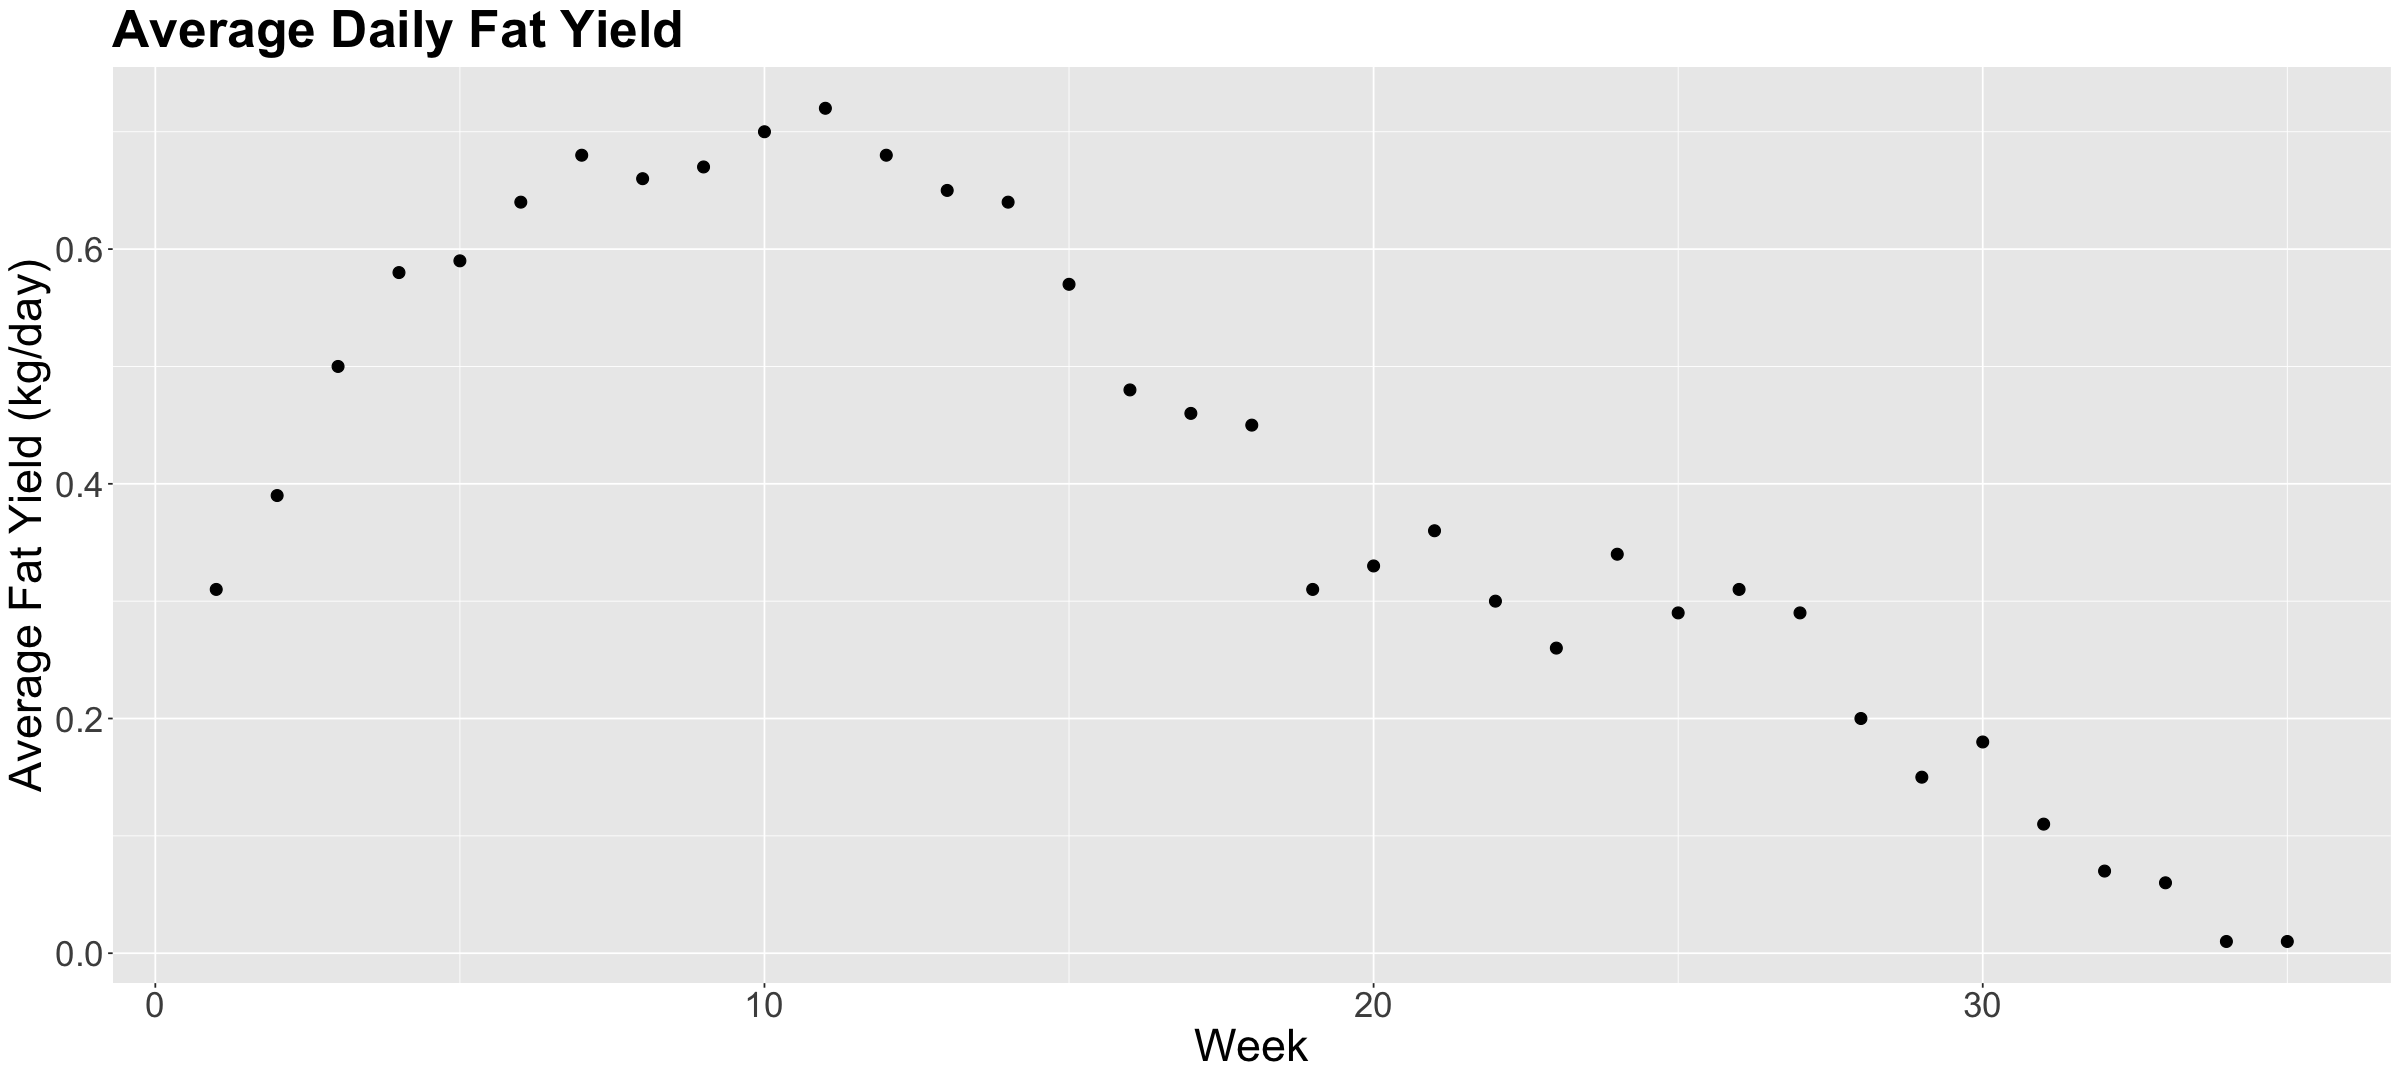

In [3]:
options(repr.plot.height = 9, repr.plot.width = 20)

plot_cow <- fat_content %>% 
  ggplot(aes(week, fat)) +
  geom_point(size = 3) +
  labs(x = "Week", y = "Average Fat Yield (kg/day)") +
  ggtitle("Average Daily Fat Yield") +
  theme(
    plot.title = element_text(size = 31, face = "bold"),
    axis.text = element_text(size = 21),
    axis.title = element_text(size = 27))        
plot_cow

Let us fit a piecewise constant regression with $q = 4$ knots.

In [4]:
# Define the number of step functions (q + 1)
breaks_q <- 5

# Create the steps for week.
fat_content <- fat_content %>% mutate(steps = cut(fat_content$week, breaks = breaks_q, 
  right = FALSE))
# Checking levels in steps
levels(fat_content$steps)

# Showing the new column steps.
head(fat_content)
tail(fat_content)

[1] "[0.966,7.8)" "[7.8,14.6)"  "[14.6,21.4)" "[21.4,28.2)" "[28.2,35)"

week,fat,steps
<dbl>,<dbl>,<fct>
1,0.31,"[0.966,7.8)"
2,0.39,"[0.966,7.8)"
3,0.50,"[0.966,7.8)"
4,0.58,"[0.966,7.8)"
5,0.59,"[0.966,7.8)"
6,0.64,"[0.966,7.8)"


week,fat,steps
<dbl>,<dbl>,<fct>
30,0.18,"[28.2,35)"
31,0.11,"[28.2,35)"
32,0.07,"[28.2,35)"
33,0.06,"[28.2,35)"
34,0.01,"[28.2,35)"
35,0.01,"[28.2,35)"


We can now fit the `model_steps` with `formula = fat ~ steps` via `lm()`.

```{attention}
Note that `estimate` is the difference between each category with respect to the baseline `[0.966,7.8)`.
```

In [5]:
model_steps <- lm(fat ~ steps, data = fat_content)
tidy(model_steps) %>% mutate_if(is.numeric, round, 3)
glance(model_steps) %>% mutate_if(is.numeric, round, 3)

term,estimate,std.error,statistic,p.value
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
(Intercept),0.527,0.031,16.897,0.000
"steps[7.8,14.6)",0.147,0.044,3.335,0.002
"steps[14.6,21.4)",-0.104,0.044,-2.364,0.025
"steps[21.4,28.2)",-0.243,0.044,-5.504,0.000
"steps[28.2,35)",-0.443,0.044,-10.037,0.000


r.squared,adj.r.squared,sigma,statistic,p.value,df,logLik,AIC,BIC,deviance,df.residual,nobs
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0.875,0.859,0.083,52.648,0,4,40.34,-68.68,-59.348,0.204,30,35


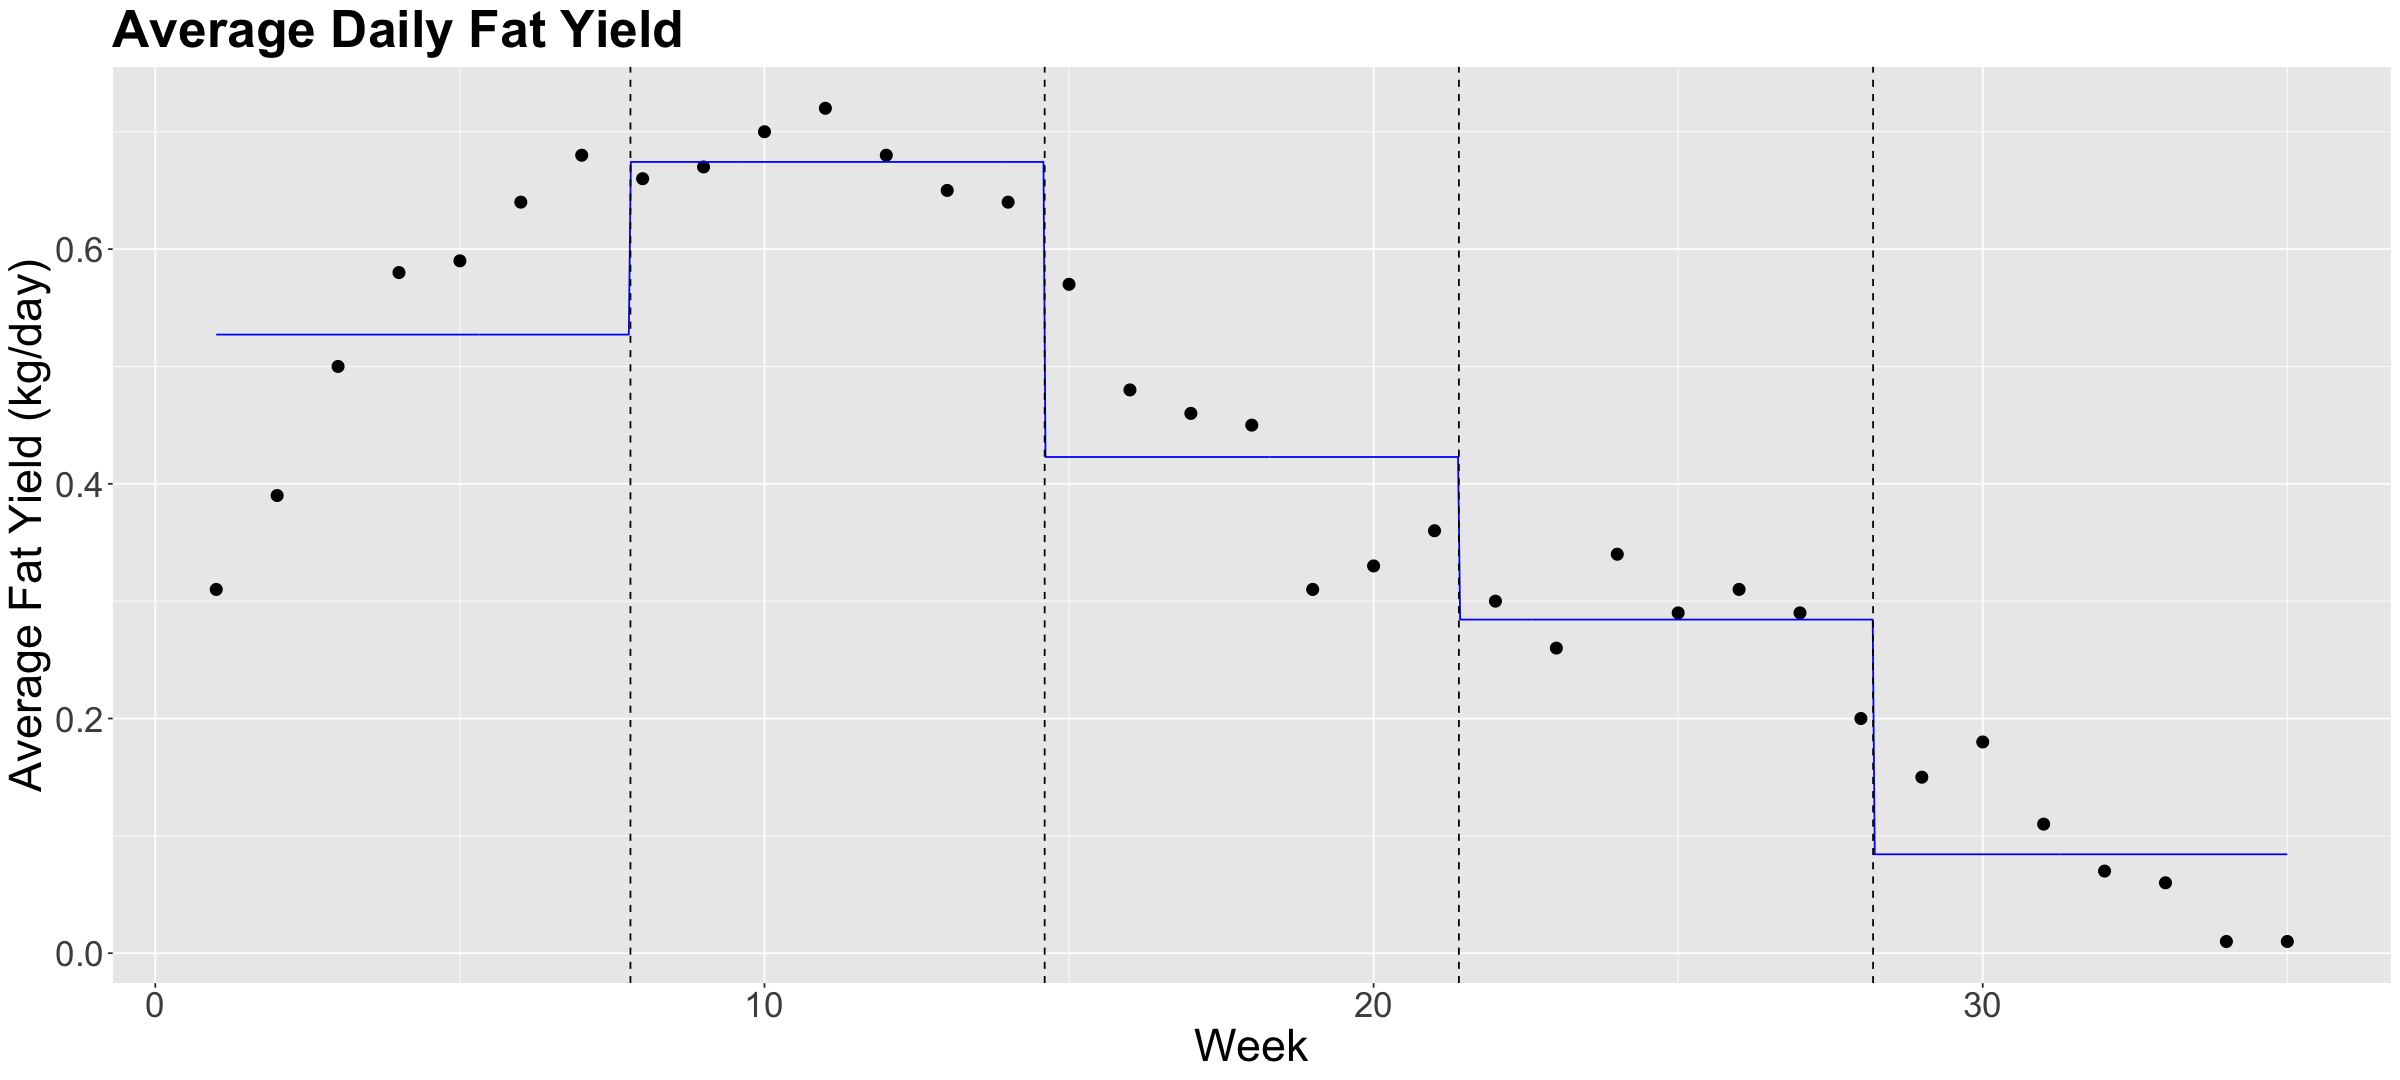

In [6]:
# Creating the grid for predictions.
grid <- fat_content %>%
  data_grid(week = seq_range(week, 1000)) %>%
  mutate(steps = cut(week, breaks_q, right = FALSE)) %>%
  add_predictions(model_steps)

# Creating labels and plotting values for the knots.
labs <- levels(fat_content$steps)
steps <- tibble(
  lower = as.numeric(sub("\\[(.+),.*", "\\1", labs)),
  upper = as.numeric(sub("[^,]*,([^]]*)\\)", "\\1", labs))
)

# Plotting.
plot_cow +
  geom_line(aes(week, pred), data = grid, color = "blue") +
  geom_vline(xintercept = steps$lower[-1], linetype = "dashed")

In [7]:
grid

week,steps,pred
<dbl>,<fct>,<dbl>
1.000000,"[0.966,7.8)",0.5271429
1.034034,"[0.966,7.8)",0.5271429
1.068068,"[0.966,7.8)",0.5271429
1.102102,"[0.966,7.8)",0.5271429
1.136136,"[0.966,7.8)",0.5271429
⋮,⋮,⋮
34.86386,"[28.2,35)",0.08428571
34.89790,"[28.2,35)",0.08428571
34.93193,"[28.2,35)",0.08428571


```{exercise}
:label: lecture6-q1

Discuss the importance of this class of a local regression strategy of having breakpoints by regressor when having prediction inquiries. 
```

### 1.2. Non-Continuous Piecewise Linear Regression

Note in the previous plot, though, that the functions should not be constant inside an interval. Instead, **there is an approximately linear behaviour in each interval**.

**Can we capture that? Yes we can!**

All we need to do, is to add $\color{green}{\text{interaction terms}}$ between the step functions $C_j(X_i)$, for $j = 1, \dots, q$, with $X_i$:

```{math}
\begin{equation*}
Y_i = \beta_0 + \color{red}{\beta_1 C_1(X_i) + \dots + \beta_q C_q(X_i)} + \beta_{q + 1} X_i + \color{green}{\beta_{q + 2} X_i C_1(X_i) + \dots + \beta_{2q + 1} X_i C_q(X_i)} + \varepsilon_i.
\end{equation*}
```

Let us see what happens in this model:

- If $X_i < c_1$, then our model is: $Y_i = \beta_0 + \beta_{q + 1}X_i$
- If $c_1 \leq X_i < c_2$, then our model is: $Y_i = \beta_0 + \color{red}{\beta_1} + (\beta_{q + 1} + \color{green}{\beta_{q + 2}}) X_i$
- If $c_2 \leq X_i < c_3$, then our model is: $Y_i = \beta_0 + \color{red}{\beta_2} + (\beta_{q + 1} + \color{green}{\beta_{q + 3}}) X_i$

$$\vdots$$

- If $c_{q-1} \leq X_i < c_q$, then our model is: $Y_i = \beta_0 + \color{red}{\beta_{q -1}} + (\beta_{q + 1} + \color{green}{\beta_{2q}}) X_i$
- If $c_q \leq X_i$, then our model is: $Y_i = \beta_0 + \color{red}{\beta_q} + (\beta_{q + 1} + \color{green}{\beta_{2q + 1}}) X_i$

So, for each interval, we have an $\color{red}{\text{additional intercept}}$ and an $\color{green}{\text{additional slope}}$.

Now, we will check if the model fitting looks better in `fat_content`. Note that the right hand side in the `formula`, within `lm()`, is merely a model with interaction `week * steps`.

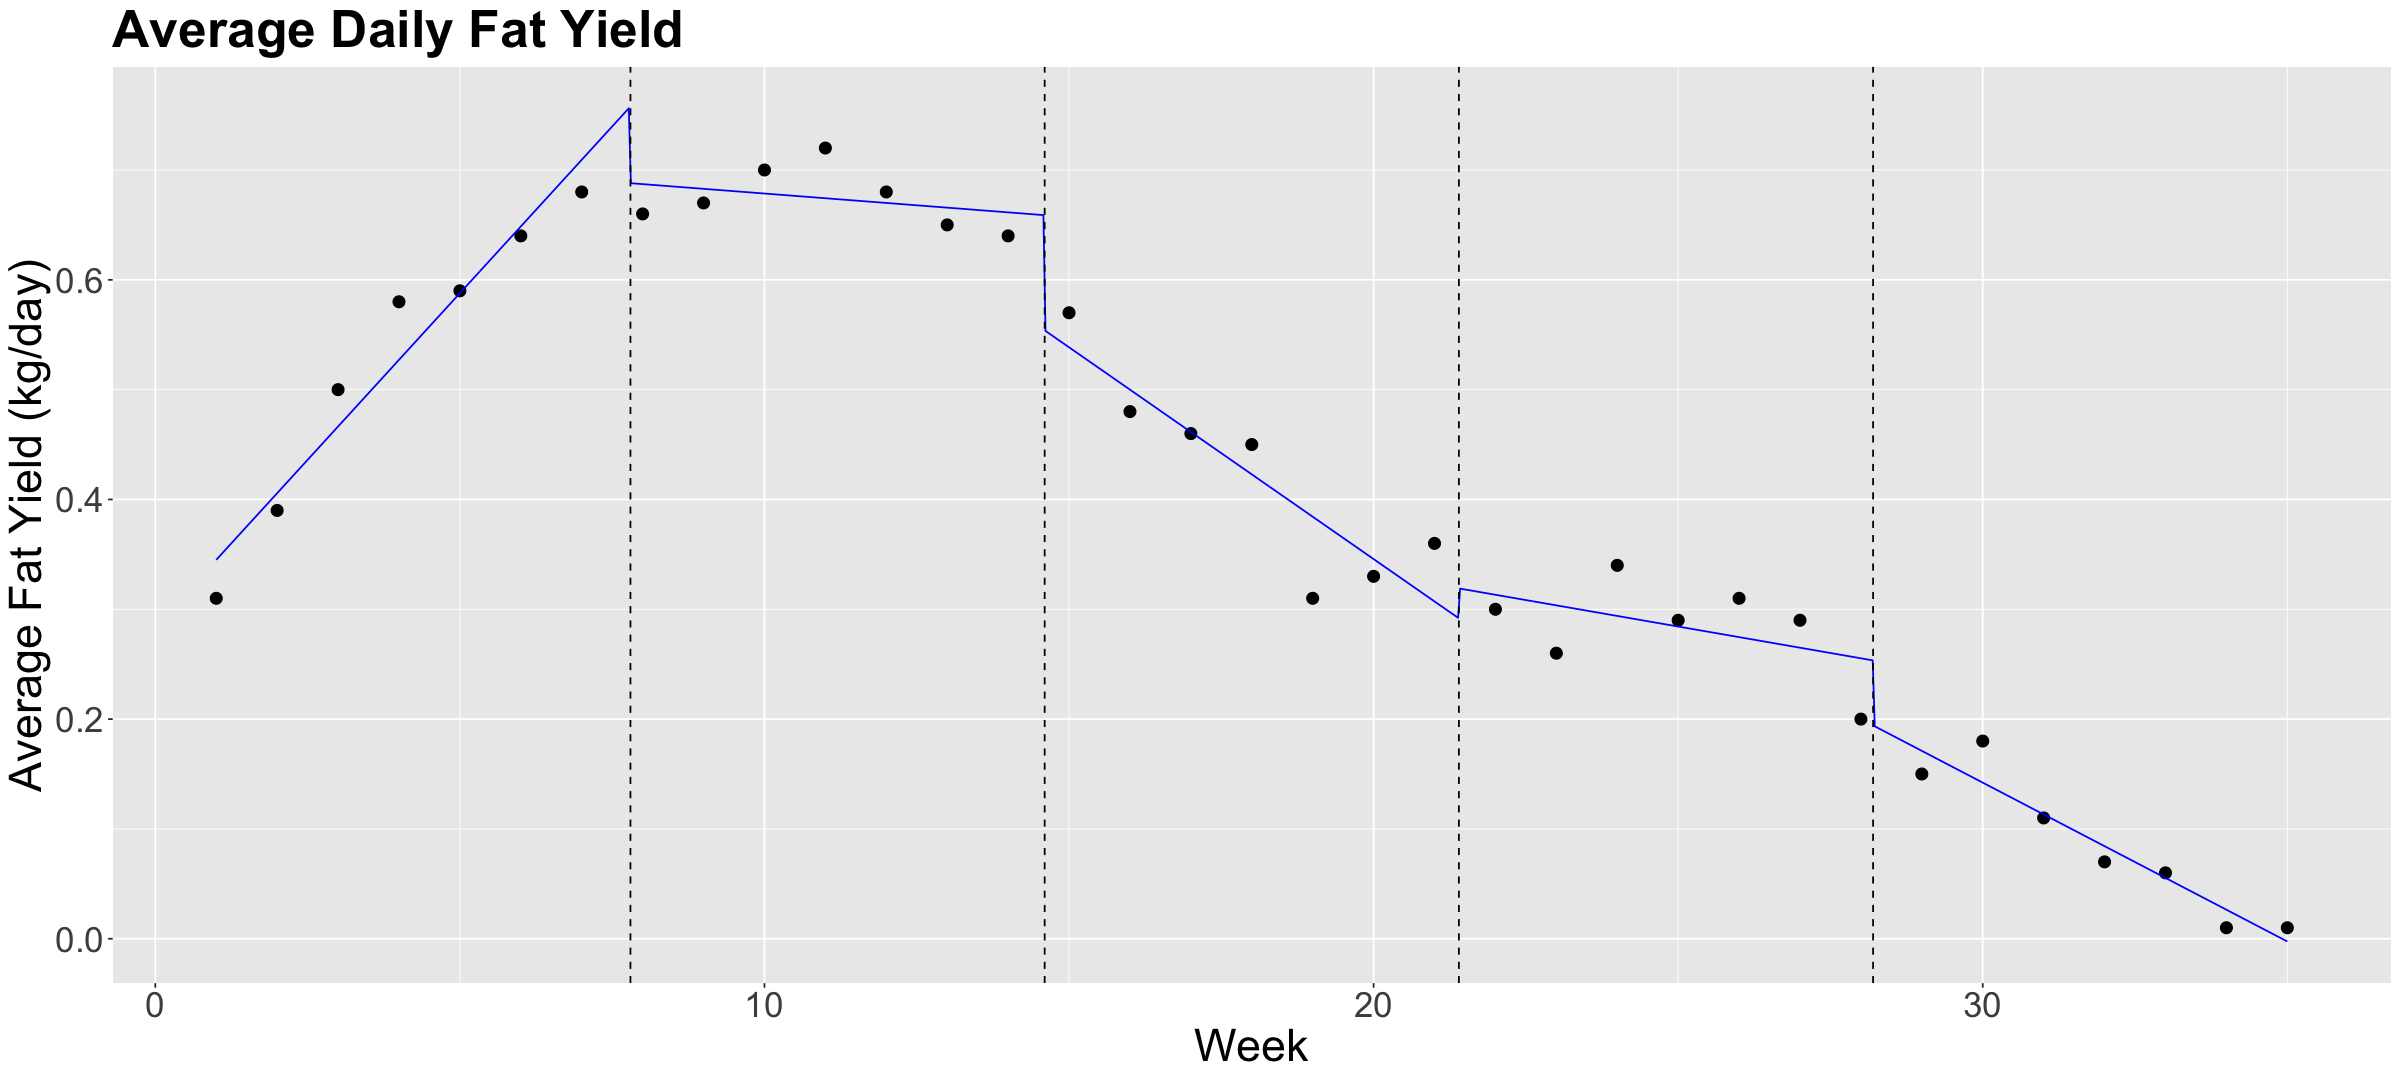

In [8]:
# We need to add the interaction between steps and week.
model_piecewise_linear <- lm(fat ~ week * steps, data = fat_content)

## Let us create our grid for predictions,
grid <- fat_content %>%
  data_grid(week = seq_range(week, 1000)) %>%
  mutate(steps = cut(week, breaks_q, right = FALSE)) %>%
  add_predictions(model_piecewise_linear)

## Plotting
plot_cow +
  geom_line(aes(week, pred), data = grid, color = "blue") +
  geom_vline(xintercept = steps$lower[-1], alpha = 1, linetype = "dashed")

Let us check the model's summary.

In [9]:
tidy(model_piecewise_linear) %>% mutate_if(is.numeric, round, 3)
glance(model_piecewise_linear) %>% mutate_if(is.numeric, round, 3)

term,estimate,std.error,statistic,p.value
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
(Intercept),0.284,0.031,9.261,0.000
week,0.061,0.007,8.846,0.000
"steps[7.8,14.6)",0.437,0.083,5.289,0.000
"steps[14.6,21.4)",0.833,0.128,6.505,0.000
"steps[21.4,28.2)",0.241,0.175,1.379,0.180
"steps[28.2,35)",0.726,0.222,3.266,0.003
"week:steps[7.8,14.6)",-0.065,0.010,-6.696,0.000
"week:steps[14.6,21.4)",-0.099,0.010,-10.228,0.000
"week:steps[21.4,28.2)",-0.070,0.010,-7.248,0.000


r.squared,adj.r.squared,sigma,statistic,p.value,df,logLik,AIC,BIC,deviance,df.residual,nobs
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0.98,0.973,0.036,135.294,0,9,72.264,-122.528,-105.419,0.033,25,35


However, the local regression lines are disconnected. **Can we fix that?**

### 1.3. Continuous Piecewise Linear Regression

We can impose **restrictions** to make sure that the lines are connected to each other. Therefore, we need to introduce the concept of the hinge function.

For the $i$th observation, this model can be defined as follows:

$$Y_i = \beta_0 + \beta_1 X_i +\beta_2 (X_i - c_1)_{+} + \dots + \beta_{q+1} (X_i - c_q)_{+} + \varepsilon_i,$$

where the hinge function for the knot $c_j$

$$
(X_i - c_j)_{+} =
\begin{cases}
0 \; \; \; \; \mbox{if $X_i < c_j$},\\
X_i - c_j \; \; \; \;   \mbox{if $X_i \geq c_j$}.
\end{cases}
$$

We do not need to fit separate OLS linear regressions but one. In the `lm()` function, within `formula` on the right-hand side along with the standalone regressor `X`, we have to add up the following term `I((X - c_j)*(X >= c_j))` **by knot `c_j`**.

We need to obtain the corresponding knots in `fat_content` ($q = 4$):

In [10]:
levels(fat_content$steps)
knots <- c(7.8, 14.6, 21.4, 28.2)

[1] "[0.966,7.8)" "[7.8,14.6)"  "[14.6,21.4)" "[21.4,28.2)" "[28.2,35)"

Now, let us fit this model.

In [11]:
model_piecewise_cont_linear <- lm(fat ~ week + I((week - knots[1]) * (week >= knots[1])) +
  I((week - knots[2]) * (week >= knots[2])) +
  I((week - knots[3]) * (week >= knots[3]))+
  I((week - knots[4]) * (week >= knots[4])),
data = fat_content
)

Now, we will check if the model fitting looks better in `fat_content`.

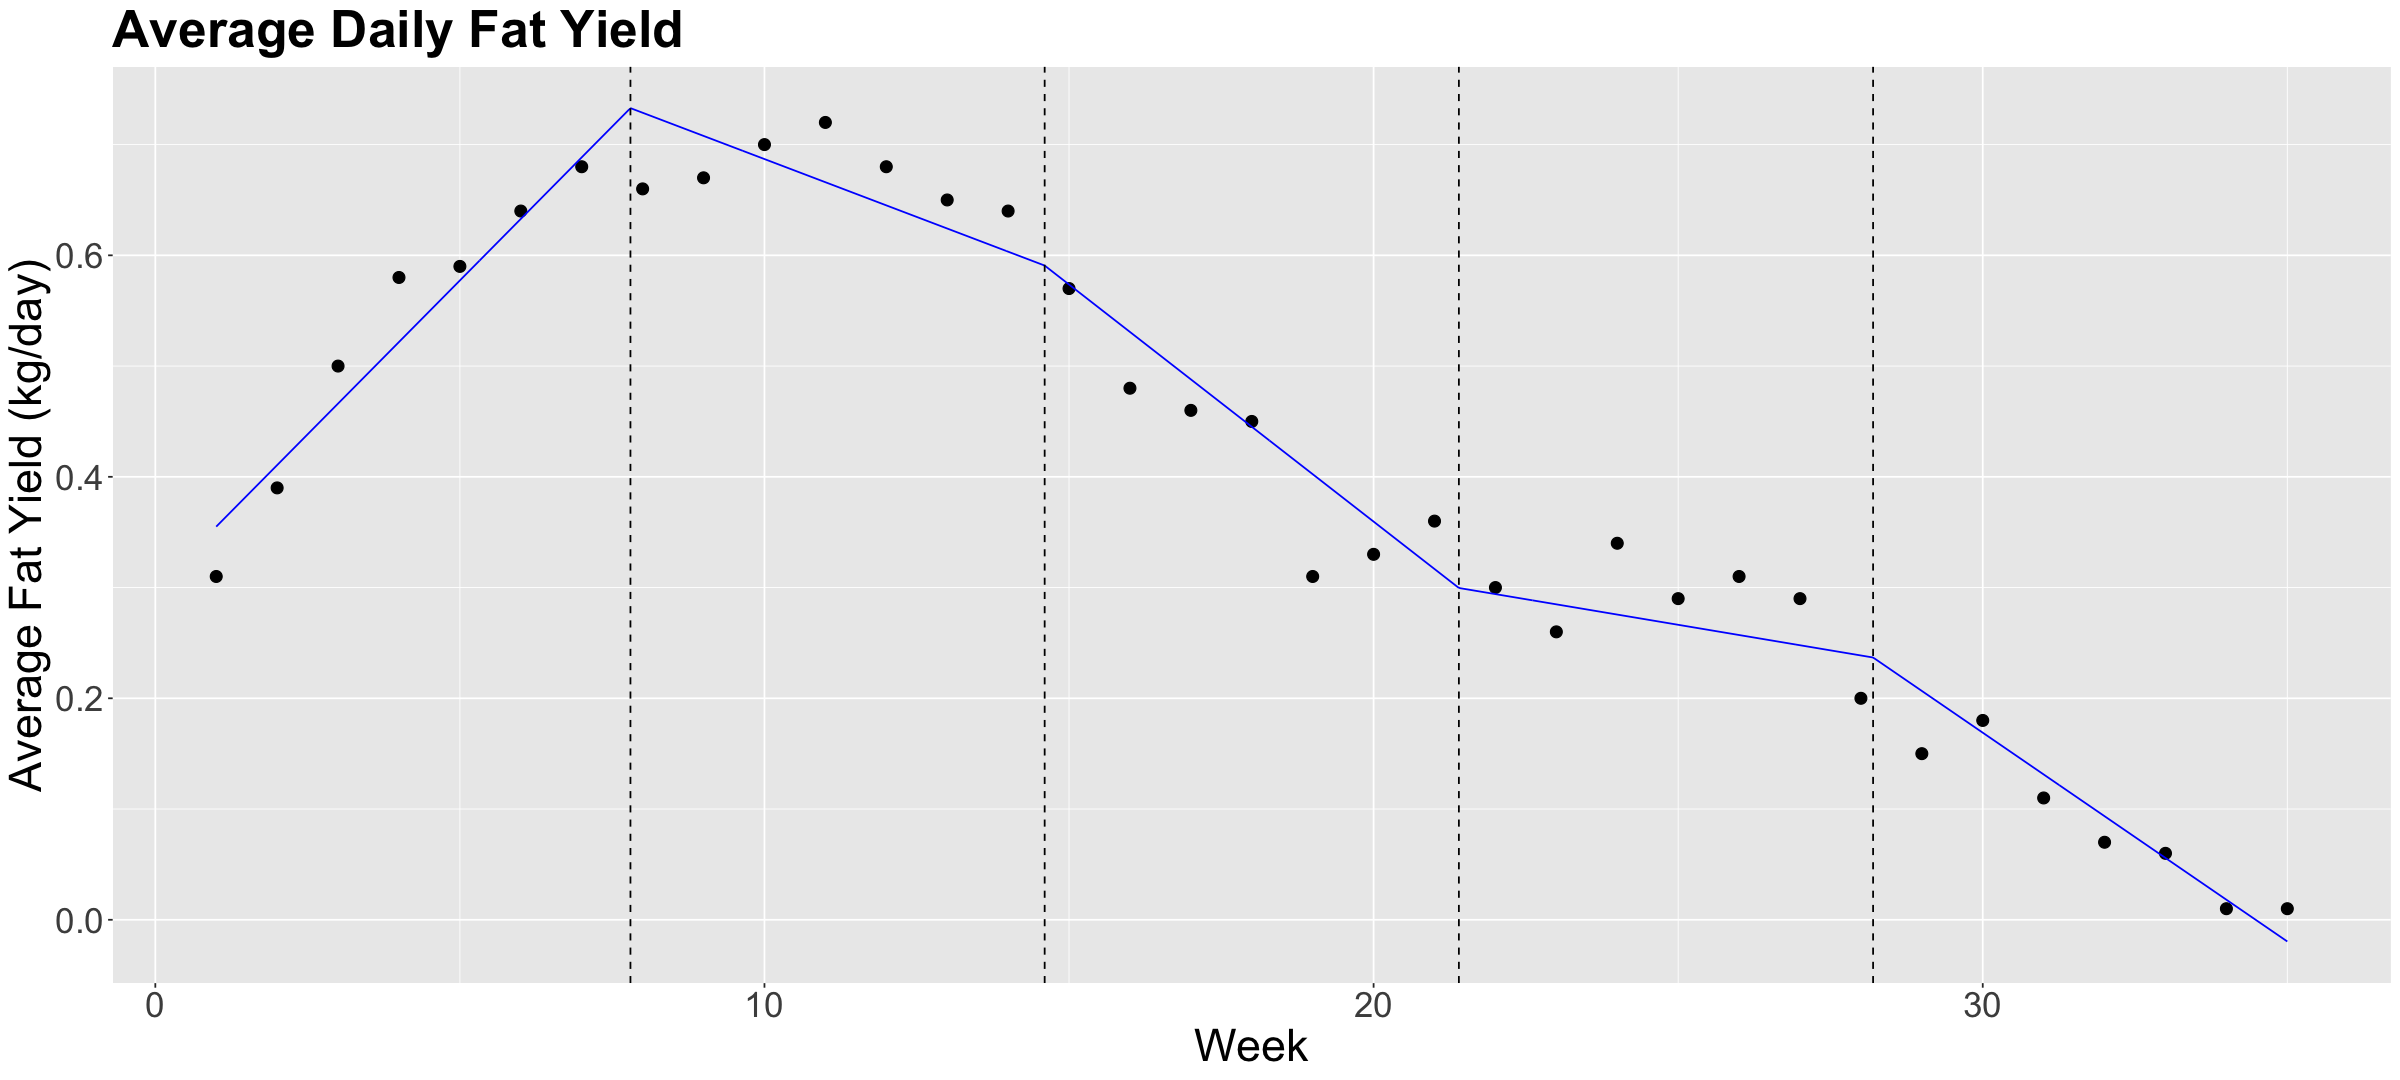

In [12]:
# Let us create our grid for predictions,
grid <- fat_content %>%
  data_grid(week = seq_range(week, 1000)) %>%
  mutate(steps = cut(week, breaks_q, right = FALSE)) %>%
  add_predictions(model_piecewise_cont_linear)

# Plotting
plot_cow +
  geom_line(aes(week, pred), data = grid, color = "blue") +
  geom_vline(xintercept = steps$lower[-1], alpha = 1, linetype = "dashed")

Let us check the model's summary.

In [13]:
tidy(model_piecewise_cont_linear) %>% mutate_if(is.numeric, round, 3)
glance(model_piecewise_cont_linear) %>% mutate_if(is.numeric, round, 3)

term,estimate,std.error,statistic,p.value
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
(Intercept),0.299,0.032,9.453,0.000
week,0.056,0.006,9.604,0.000
I((week - knots[1]) * (week >= knots[1])),-0.076,0.010,-7.854,0.000
I((week - knots[2]) * (week >= knots[2])),-0.022,0.009,-2.414,0.022
I((week - knots[3]) * (week >= knots[3])),0.034,0.009,3.700,0.001
I((week - knots[4]) * (week >= knots[4])),-0.028,0.010,-2.924,0.007


r.squared,adj.r.squared,sigma,statistic,p.value,df,logLik,AIC,BIC,deviance,df.residual,nobs
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0.969,0.963,0.042,180.119,0,5,64.587,-115.175,-104.287,0.051,29,35


## 2. $k$-NN Regression

```{attention} 
I have been using the letter $k$ to denote the number of regressors in any general regression model. Nevertheless, this letter is reserved for groups of $k$ observations in this framework. Therefore, I will switch to the letter $p$ to denote the number of regressors in this framework. 
```

The idea behind $k$-NN regression is finding the $k$ observations **in our training dataset of size $n$ (with $p$ features $x_j$ per observation)** closest to the new point we want to predict. 

Next, we calculate the average $\bar{y}^{(k)}$ of the responses of those $k$ observations. That is our new prediction.

How do we obtain those $k$ observations? **Based on the values of the respective $p$ features**, we determine which $k$ observations (out from the $n$ in the training set) have the smallest distance metric (e.g., Euclidean distance $D^{(\text{Training, New})}$) to the **features of the new point**.

$$
D^{(\text{Training, New})} = \sqrt{\sum_{j = 1}^p \Big( x_j^{\text{(Training)}} - x_j^{\text{(New)}} \Big)^2}
$$

```{important}
We would compute $n$ distances $D^{(\text{Training, New})}$ using the same "New" observation. Then, there will be $k$ "Training" observations to be chosen out of these $n$ distances (where $n$ represents the total number of training data points).
```

Things to keep in mind:

1. If $k = 1$, there will be **no training error**. Nevertheless, **we might (and probably will) overfit badly**. 
2. As we increase $k$, more **"smooth"** the regression will be. At some point, **we will start underfitting**.

```{exercise}
:label: lecture6-q2

What are the consequences of overfitting a training set in further test sets?

**A.** There are no consequences at all; predictions will be highly accurate in any further test set.

**B.** The trained model will be so oversimplified that we will have a high bias in further test set predictions.

**C.** The trained model will be so overfitted that it will also explain random noise in training data. Therefore, we cannot generalize this model in further test set predictions.
```

Now let us run $k$-NN algorithm on the `fat_content` dataset.

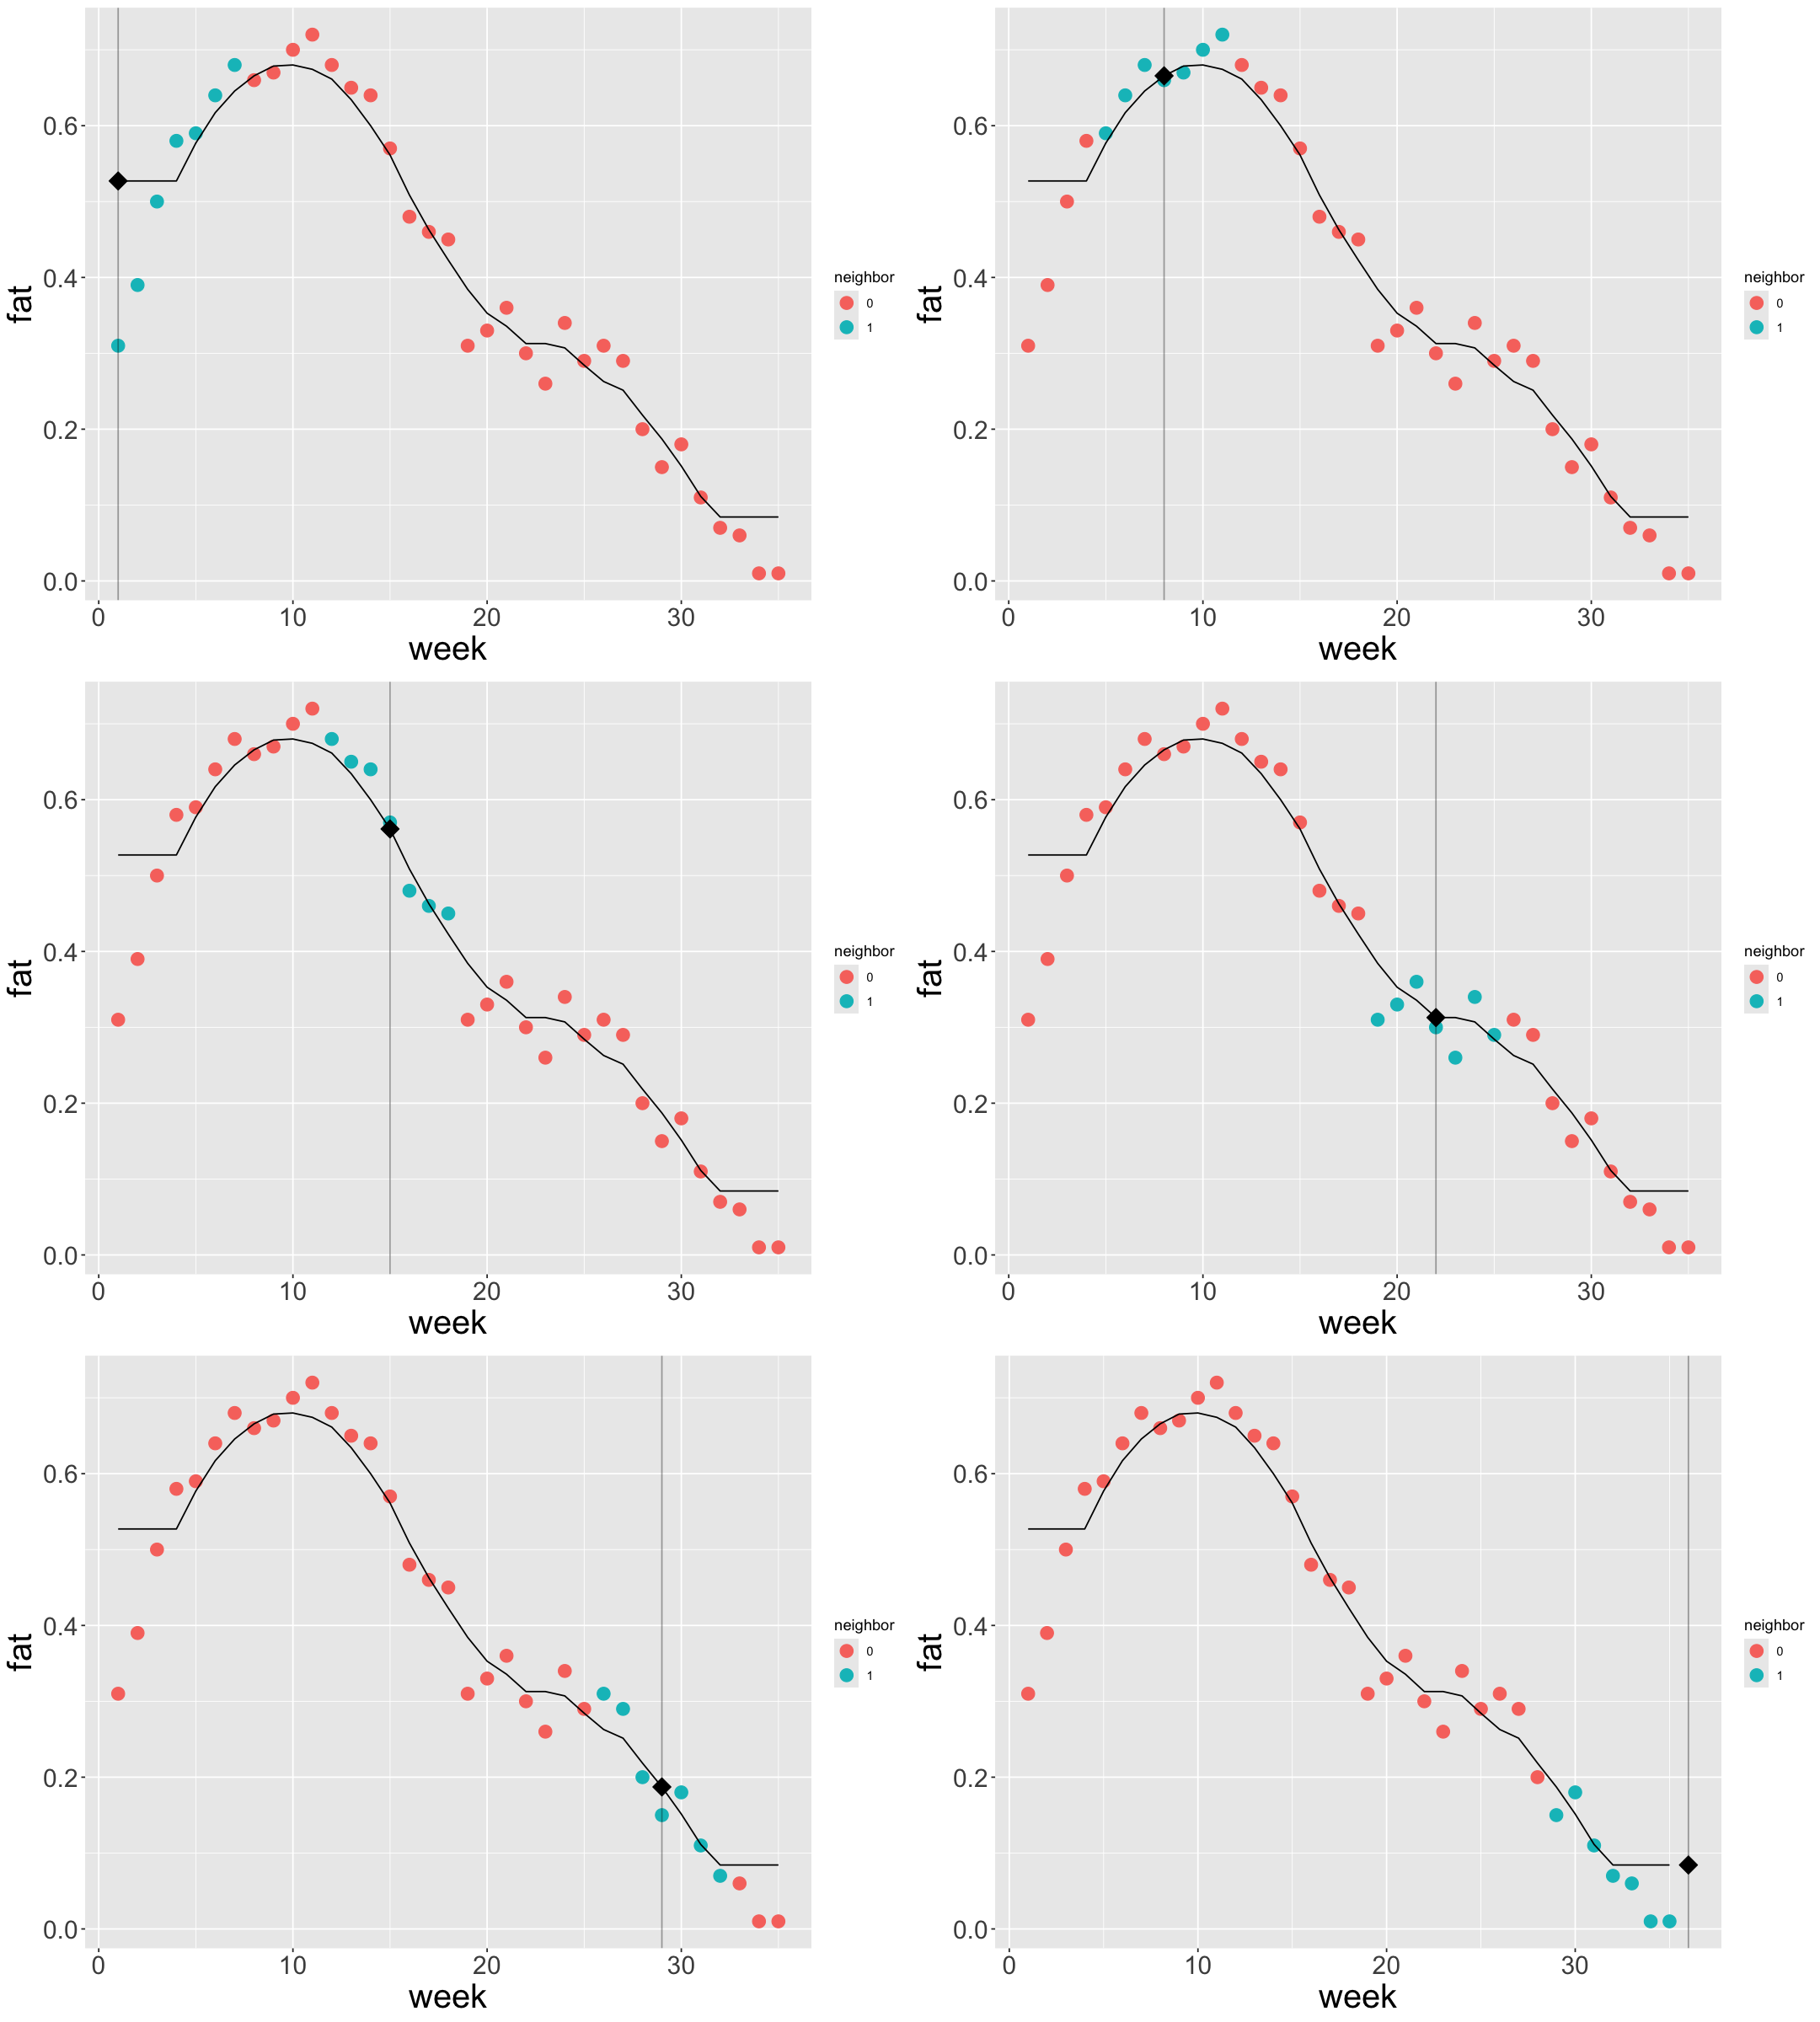

In [14]:
options(repr.plot.height = 20, repr.plot.width = 18)

k <- 7 # Use odd numbers here so there is no missmatch on how the ties are handled.

## Running k-NN regression
my_knn <- knnreg(fat ~ week, data = fat_content, k = k)
grid <- fat_content %>%
  data_grid(week) %>%
  add_predictions(my_knn)

## Generating the plots.
p <- list()
for (i in 1:6) {
  p[[i]] <- knn_plot((i - 1) * 7 + 1, k) + geom_line(aes(week, pred), data = grid)
}

grid.arrange(grobs = p, ncol = 2)

## 3. Locally Weighted Scatterplot Smoother (LOWESS) Regression

Suppose we want to predict the response $y$ for a given $x$. For example, we want to predict the fat content of cow milk in `week` 10. The idea of LOWESS is:

1. Find the closest points to `week` 10 (how many points is a parameter that we define).
2. From the selected points, we assign weights based on these distances. The closest the point is, the more weight it will receive (weights are determined as in weighted least-squares by default in `loess()`).
3. Next, for the $i$th point in the `span`, using weighted least-squares for a **second `degree` polynomial** for instance, we minimize the sum of squared errors considering the weight $w_i$ as follows:
   
$$
\sum_i w_i \left(y_i - \beta_0-\beta_1 x_i-\beta_2 x_i^2\right)^2
$$

```{important}
Roughly speaking, weighted least-squares allow us to assume a different variance $\sigma_{x_i}^2$ for the $i$th observation (i.e., it can be shown mathematically that $w_i = 1 / \sigma_{x_i}^2$). This model will enable us to deal with heteroscedasticity.
```

Now, there are a couple of things to consider in `loess()`: 

- The parameter `span` (between `0` and `1`) defines the "size" of your neighbourhood. To be more exact, it specifies the proportion of points considered as neighbours of $x$. **The higher the proportion, the smoother the fitted surface will be.**
- The parameter `degree`, specifies if you are fitting a constant (`degree`= 0), a linear model (`degree` = 1), or a quadratic model (`degree` = 2). By quadratic, we mean $\beta_0+\beta_1 x_i+\beta_2 x_i^2$.

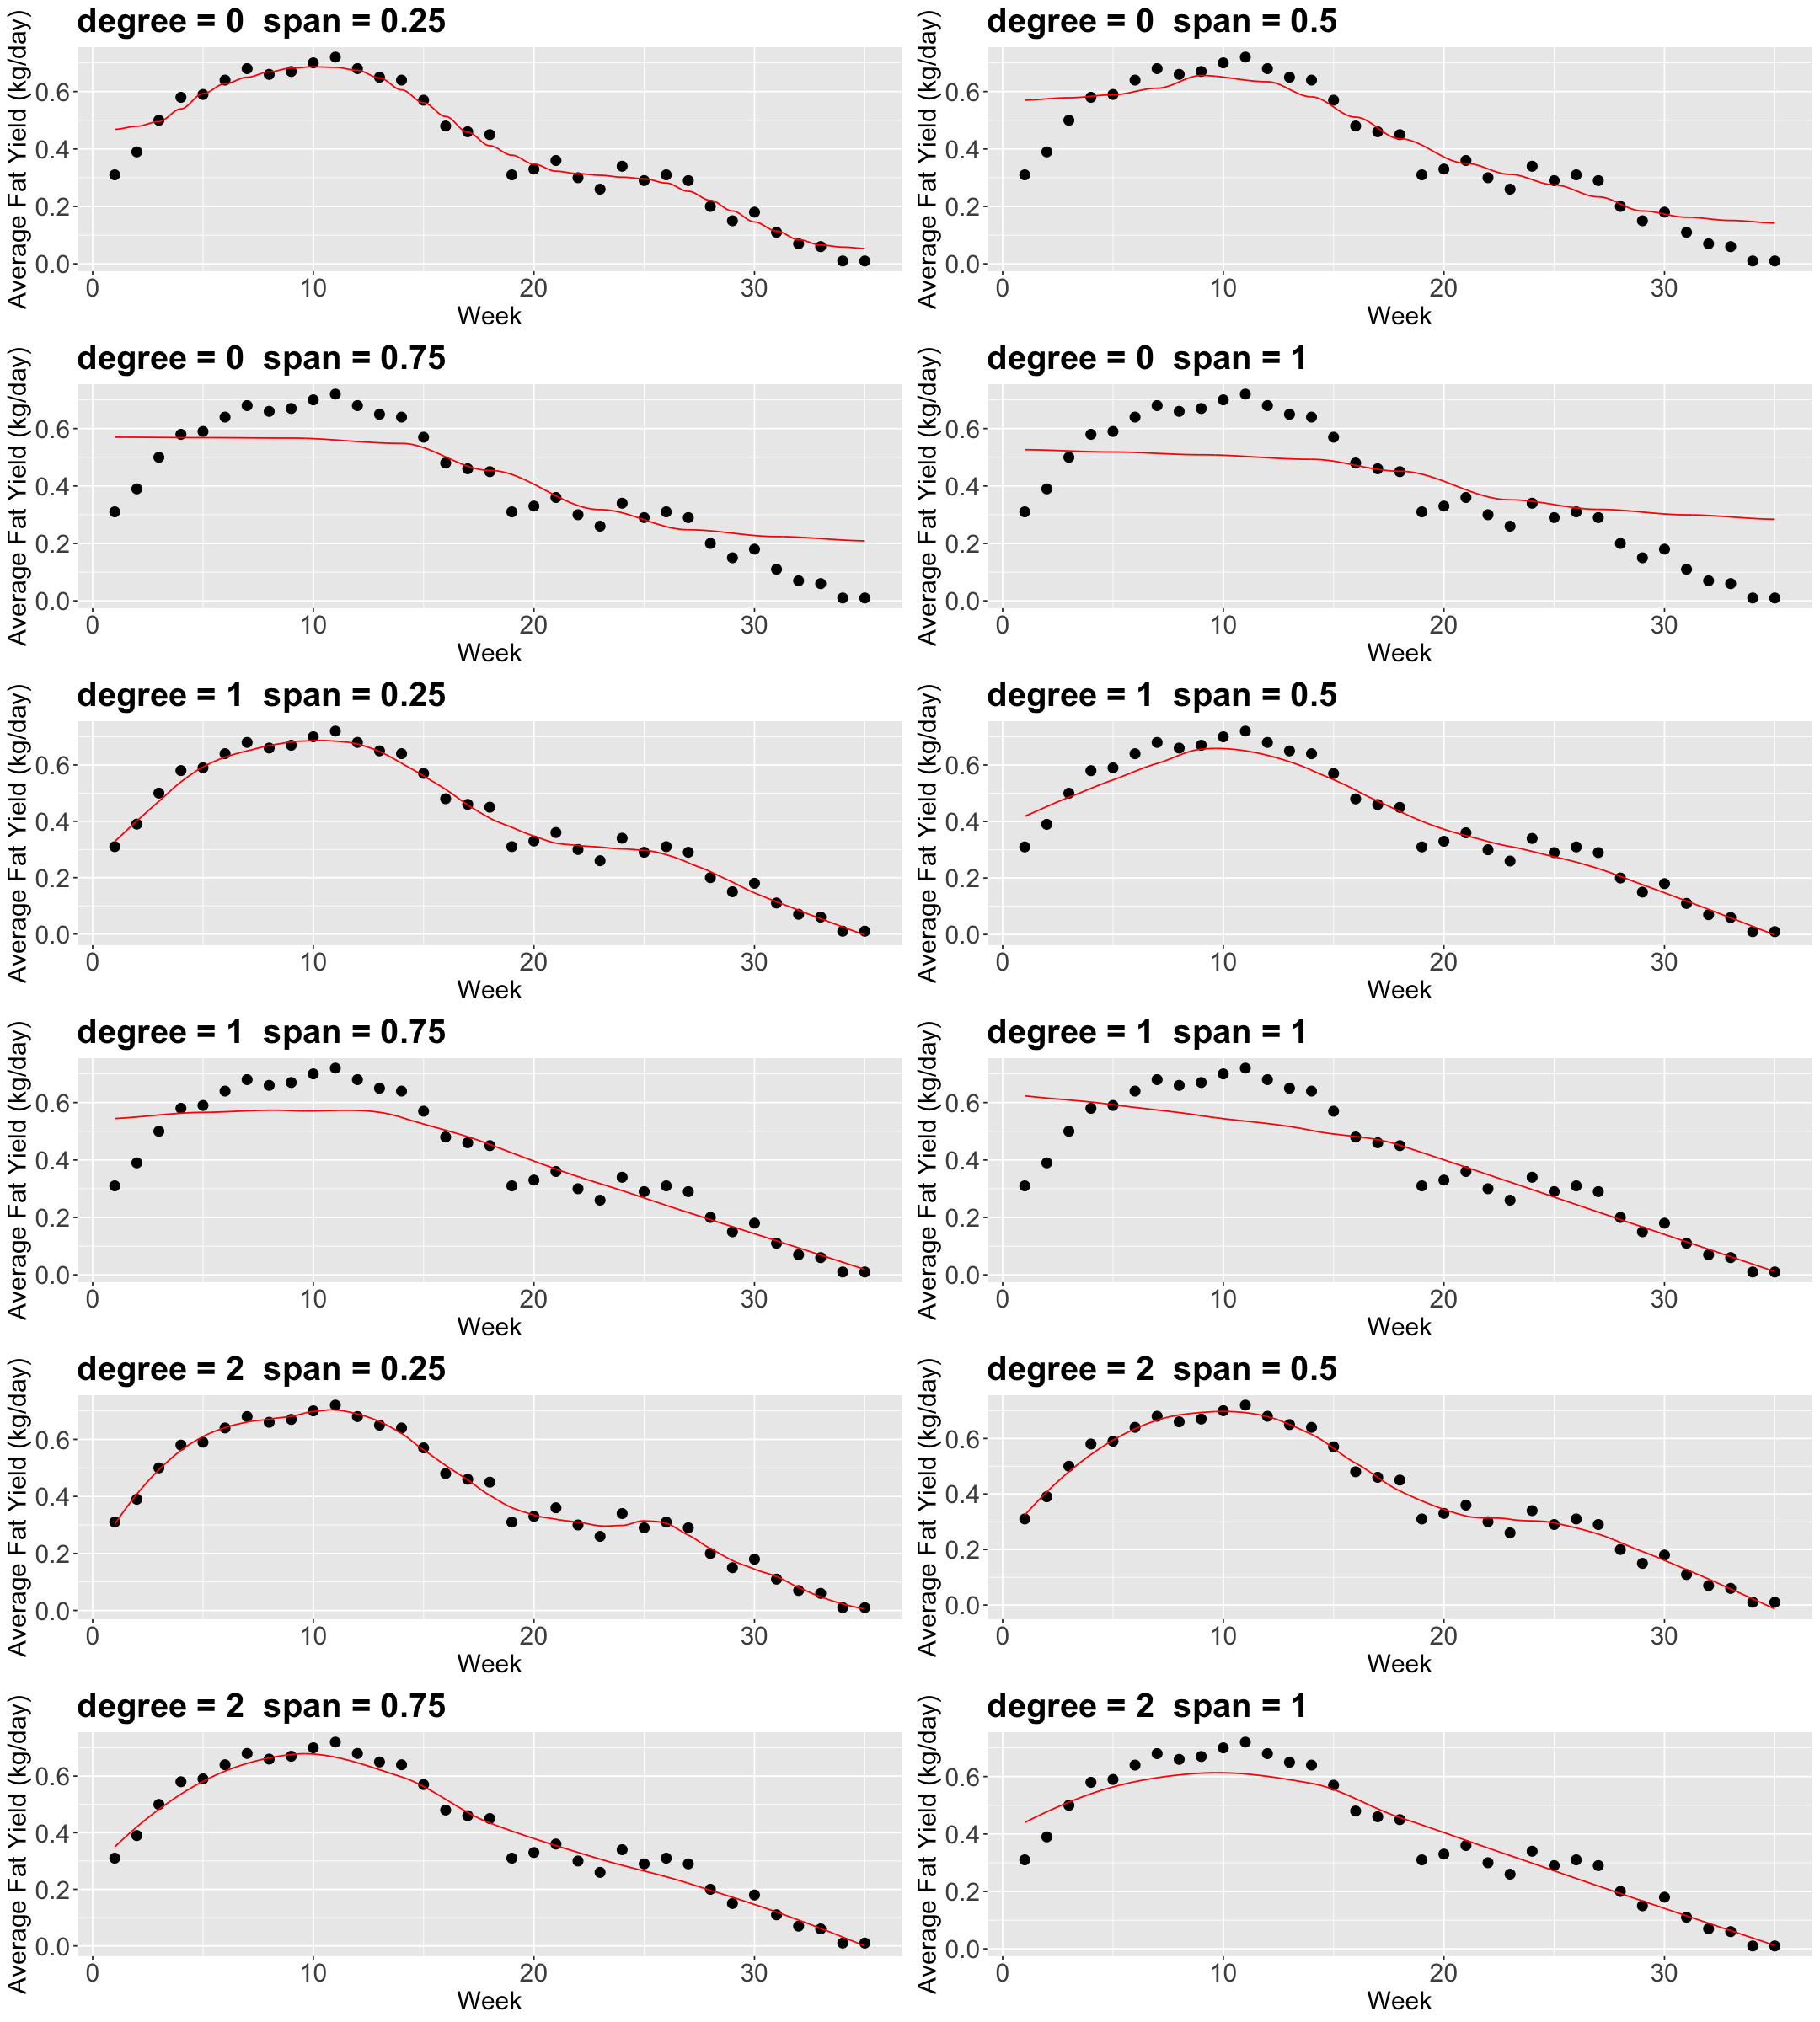

In [15]:
p <- list()
i <- 1
for (degree in seq(0, 2, 1)) {
  for (span in seq(0.25, 1, 0.25)) {
    
    suppressWarnings(model_loess <- loess(fat ~ week, span = span, degree = degree, data = fat_content))

    # We create our grid for predictions.
    grid <- fat_content %>%
      data_grid(week = seq_range(week, 1000)) %>%
      add_predictions(model_loess)

    # Plotting.
    p[[i]] <- plot_cow +
      geom_line(aes(week, pred), data = grid, color = "red") +
      theme(
        plot.title = element_text(size = 24),
        axis.text = element_text(size = 18),
        axis.title = element_text(size = 18)
      ) +
      ggtitle(paste0("degree = ", degree, "  span = ", span))

    i <- i + 1
  }
}

grid.arrange(grobs = p, ncol = 2)

## 4. Wrapping Up

- Local regression is a great tool for addressing predictive inquiries.
- Nonetheless, we will lose our inferential interpretability.
- The key concept in local regression techniques is "how local we want our model to be."